In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
#import matplotlib.pyplot as py
#import seaborn as sns
import statsmodels.api as sm

In [3]:
### Input expression data
gene_expr_body = pd.read_table("/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices/VOOMCounts_CPM5_counts4M_covfree_body_ctrl_onlygenesinmainchr_Jul20.21.txt")
gene_expr_head = pd.read_table("/Genomics/ayroleslab2/lamaya/bigProject/eQTLcatalog/modularity/matrices/VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21.txt")

In [4]:
gene_expr_dict = {"head": gene_expr_head.T, "body": gene_expr_body.T}

In [5]:
gene_expr_dict["head"].mean(axis=0)

FBgn0031081     5.093763
FBgn0052350     3.535541
FBgn0024733    11.816455
FBgn0040372     3.972505
FBgn0023534     4.186527
                 ...    
FBgn0031318     5.024348
FBgn0031313     6.567976
FBgn0031305     5.238079
FBgn0016926     7.766387
FBgn0003310     4.660298
Length: 5584, dtype: float64

In [6]:
X_head = (gene_expr_dict["head"] - gene_expr_dict["head"].mean()) / np.sqrt(gene_expr_dict["head"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_head_corr = oa.fit(X_head)

X_body = (gene_expr_dict["body"] - gene_expr_dict["body"].mean()) / np.sqrt(gene_expr_dict["body"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_body_corr = oa.fit(X_body)

gene_expr_OAS_corr = {"head": regularized_head_corr, 
                      "body": regularized_body_corr}

In [10]:
g = load_graph("VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21_regularized_correlations_precisions_spearman_correlation_cutoff_0.1.xml.gz")

In [ ]:
g_significant = GraphView(g, g.get_total_degrees(g.get_vertices()) > 1 )
g_significant = GraphView(g_significant, g_significant.get_total_degrees(g_significant.get_vertices()) > 1 )
g_significant

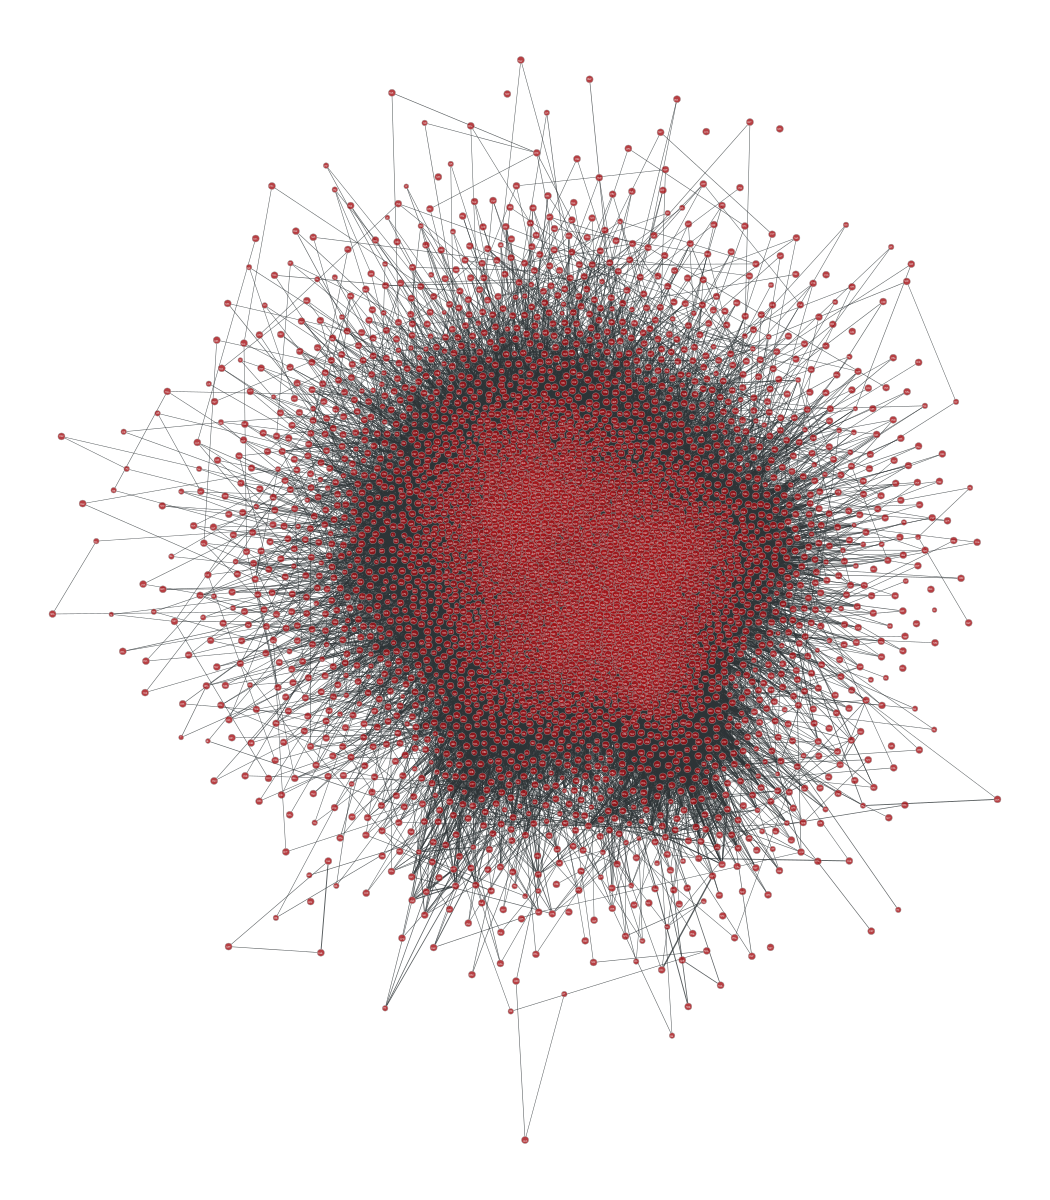

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2ca1d1c310, at 0x7f2ca1d1c640>

In [10]:
graph_draw(g_significant, vertex_text=g.vertex_index, edge_pen_width=g.edge_properties["correlation"])

In [12]:
def filterByEdge(g, corr, cutOff, keepOnlyMain):
    # Filtering edges
    corr = g.edge_properties[corr]
    sign = g.new_ep("bool", True)
    sign.a = np.array(corr.a > cutOff)

    tv = GraphView(g, efilt=sign)

    # Keeping largest component
    if keepOnlyMain:
        comp, hist = label_components(tv)
        main_component = tv.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
        tv.vertex_properties["main_component"] = main_component
        tv.set_vertex_filter(main_component)
    return tv

In [13]:
tv = filterByEdge(g, "spearman", 0.45, True)
gf = Graph(tv, prune = True)

In [14]:
N = len(gf.get_vertices())
Et = (N * N - N)/2
E = len(gf.get_edges())
E/Et

0.024434828954729055

In [15]:
gf

<Graph object, undirected, with 2022 vertices and 49926 edges, 2 internal vertex properties, 5 internal edge properties, at 0x7efcfeef2d30>

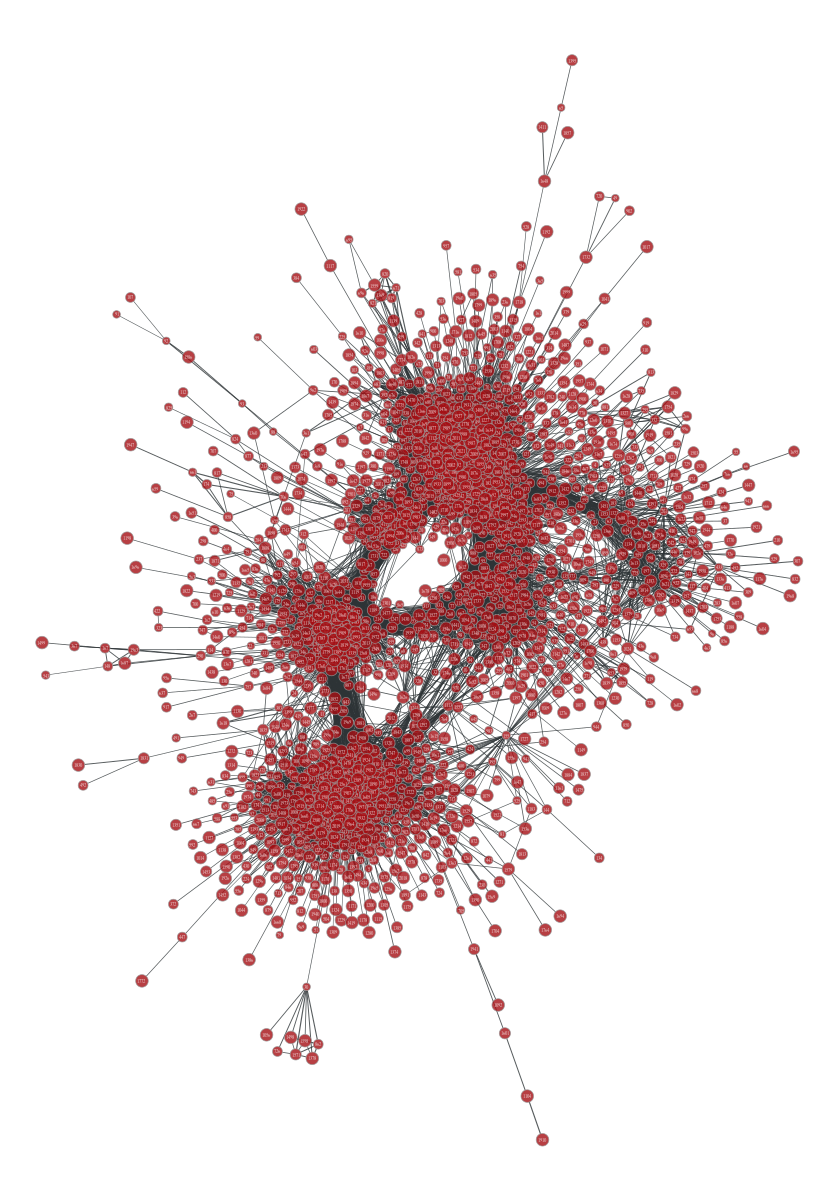

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efcfeef2d30, at 0x7efcff0b0460>

In [16]:
graph_draw(gf, vertex_text=gf.vertex_index, edge_pen_width=gf.edge_properties["correlation"])

In [17]:
gene_list = []
for i in gf.vertex_properties['genes']:
    gene_list.append(i)
gene_expr_head.T[gene_list].T.to_csv("../data/VOOMCounts_CPM5_counts4M_covfree_head_ctrl_onlygenesinmainchr_Jul20.21_filtered_by_correlation-0.45.csv")

In [18]:
corr = gf.edge_properties["correlation"]
n_trials = 10
state_nn_min_list = []
for i in range(n_trials):
    print(i)
    #state_min = minimize_blockmodel_dl(gf, state_args=dict(recs=[corr],
    #                                                       rec_types=["real-normal"]))
    state_min = minimize_blockmodel_dl(gf)
    state_nn_min_list.append(state_min)

0
1
2
3
4
5
6
7
8
9


In [19]:
state_nn_min_list

[<BlockState object with 2022 blocks (41 nonempty), degree-corrected, for graph <Graph object, undirected, with 2022 vertices and 49926 edges, 2 internal vertex properties, 5 internal edge properties, at 0x7efcfeef2d30>, at 0x7efcfeeec280>,
 <BlockState object with 2022 blocks (40 nonempty), degree-corrected, for graph <Graph object, undirected, with 2022 vertices and 49926 edges, 2 internal vertex properties, 5 internal edge properties, at 0x7efcfeef2d30>, at 0x7efcfeeec610>,
 <BlockState object with 2022 blocks (41 nonempty), degree-corrected, for graph <Graph object, undirected, with 2022 vertices and 49926 edges, 2 internal vertex properties, 5 internal edge properties, at 0x7efcfeef2d30>, at 0x7efcfeeb0640>,
 <BlockState object with 2022 blocks (38 nonempty), degree-corrected, for graph <Graph object, undirected, with 2022 vertices and 49926 edges, 2 internal vertex properties, 5 internal edge properties, at 0x7efcfeef2d30>, at 0x7efcfeea6340>,
 <BlockState object with 2022 blocks

In [20]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret_nn = []
state_nn_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_nn_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_nn_mcmc_list.append(state)
        ret_nn.append(x)

0


/Genomics/grid/users/damelo/.conda/envs/gt/lib/python3.9/site-packages/graph_tool/inference/blockmodel.py:383: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


1
2
3
4
5
6
7
8
9


In [21]:
description_lenghts = np.zeros(n_trials)
for j in range(n_trials):
    description_lenghts[j] = state_nn_mcmc_list[j].entropy()
min_index = np.argmin(description_lenghts)
state_min_nn = state_nn_mcmc_list[min_index]
description_lenghts

array([103740.1541774 , 103748.15935681, 103731.45683168, 103746.40946047,
       103736.65800314, 103744.00312908, 103710.93062394, 103727.08309417,
       103717.13957147, 103748.68411943])

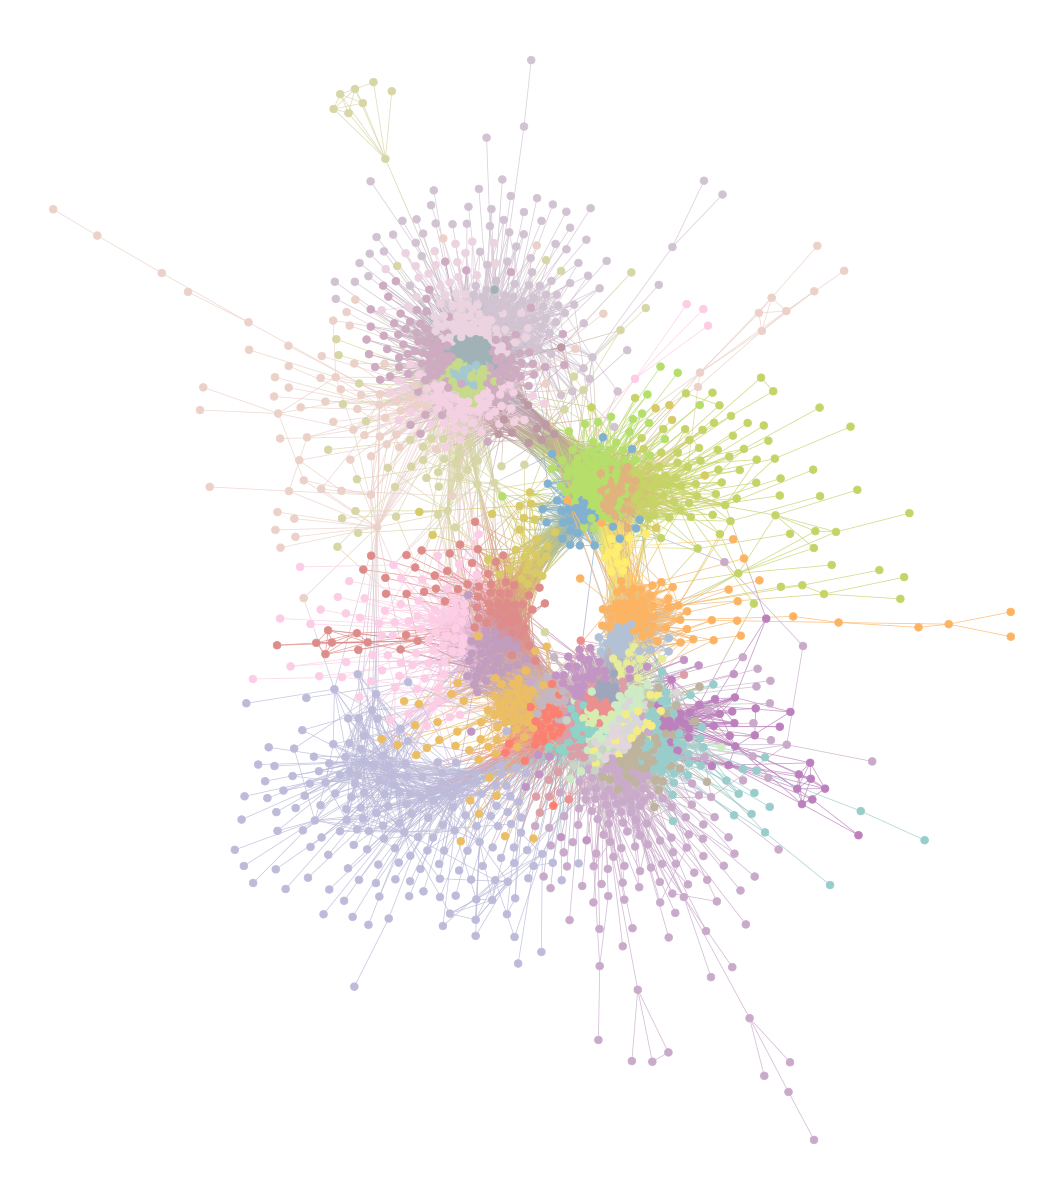

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efcfeef2d30, at 0x7efbcc8f18b0>

In [22]:
state_min_nn.draw()

In [61]:
def create_Block_df(g, state):
    genes = g.vertex_properties["genes"]
    corr = g.edge_properties["correlation"]
    block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'Block'))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [corr] )[:,2]))
        line.append(state.get_blocks()[v])
        block_df.loc[v] = line
    return block_df

In [62]:
block_df = create_Block_df(gf, state_min_nn)
block_df
block_df.to_csv("../data/1502genes-non_hierarchical_sbm-fit_head_df.csv")

In [23]:
n_trials = 1
state_min_list = []
for i in range(n_trials):
    print(i)
    #state_min = minimize_nested_blockmodel_dl(gf, state_args=dict(recs=[corr],
    #                                                              rec_types=["real-normal"]))
    state_min = minimize_nested_blockmodel_dl(gf)
    state_min_list.append(state_min)

0


In [24]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret = []
state_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_mcmc_list.append(state)
        ret.append(x)

0


In [25]:
description_lenghts = np.zeros(n_trials)
for j in range(n_trials):
    description_lenghts[j] = state_mcmc_list[j].entropy()
min_index = np.argmin(description_lenghts)
state_min = state_mcmc_list[min_index]
description_lenghts

array([100391.52970914])

In [26]:
#state_min.delete_level(5)
levels = state_min.get_levels()
len(levels)

12

In [27]:
levels = state_min.get_levels()
for s in levels:
    print(s)

<BlockState object with 1992 blocks (83 nonempty), degree-corrected, for graph <Graph object, undirected, with 2022 vertices and 49926 edges, 2 internal vertex properties, 5 internal edge properties, at 0x7efcfeef2d30>, at 0x7efcfeee8280>
<BlockState object with 85 blocks (28 nonempty), for graph <Graph object, undirected, with 1992 vertices and 997 edges, at 0x7efbcc88ed90>, at 0x7efbcc8a8520>
<BlockState object with 25 blocks (11 nonempty), for graph <Graph object, undirected, with 85 vertices and 196 edges, at 0x7efd103beee0>, at 0x7efcfee9c580>
<BlockState object with 5 blocks (3 nonempty), for graph <Graph object, undirected, with 25 vertices and 45 edges, at 0x7efbcc8b5070>, at 0x7efbcc8b2b80>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 5 vertices and 6 edges, at 0x7efbcc8b5d90>, at 0x7efbcc8b58e0>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 2 vertices and 1 edge, at 0x7efbcc8baaf0>, at 0x7e

In [84]:
state_min.draw(hsize_scale = 10, vsize_scale = 5, subsample_edges = 10000, output = 'test.png')

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efcfeef2d30, at 0x7efbc1a47a00>,
 <Graph object, directed, with 2148 vertices and 2147 edges, at 0x7efbc1a74280>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efbc1a74280, at 0x7efbc1a44f40>)

In [64]:
def get_group(x, state):
    levels = state.get_levels()
    n_levels = 5#len(levels)
    r = np.zeros(n_levels)
    r[0] = levels[0].get_blocks()[x]
    for i in range(1, n_levels):
        r[i] = levels[i].get_blocks()[r[i-1]]
    r = r.astype(int)
    return r
def create_nestedBlock_df(g, state):
    genes = g.vertex_properties["genes"]
    correlation = g.edge_properties["correlation"]
    nested_block_df = pd.DataFrame(columns=('Gene', "Degree", "E_corr", 'B1', "B2", "B3", "B4", "B5"))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [correlation] )[:,2]))
        [line.append(i) for i in get_group(v, state)]
        nested_block_df.loc[v] = line
    return nested_block_df

In [52]:
x = get_hierarchy_tree(state_min)
for i in x[0].get_vertices():
    print(x[2][i])

211
73
225
16
3
4
5
218
95
41
3
6
167
122
8
129
75
9
79
67
19
18
1
3
4
120
72
106
8
28
8
23
2
71
13
18
17
1
23
39
175
208
40
241
9
76
50
2
36
2
1
1
10
28
9
1
269
221
55
1
28
199
58
19
13
2
1
1
4
1
20
5
71
51
14
1
1
17
8
1
1
3
260
13
33
55
4
3
2
131
252
1
4
4
48
8
1
53
14
73
79
68
10
2
247
6
187
1
247
12
8
3
1
83
4
29
54
3
184
2
11
11
225
3
1
29
35
97
18
28
1
66
6
69
1
33
1
24
2
57
83
4
5
28
4
30
6
14
5
78
6
3
11
11
8
38
65
13
50
59
5
1
1
70
120
123
106
6
214
32
1
57
233
229
3
18
40
92
1
5
22
142
31
13
67
225
18
57
3
7
75
82
48
37
6
117
237
12
30
192
114
29
12
252
15
6
34
2
7
92
1
43
102
2
28
2
221
118
12
16
170
85
3
11
2
3
29
5
5
4
1
18
6
175
19
1
2
3
72
8
1
14
3
82
6
7
36
167
218
86
33
139
90
15
2
2
1
1
1
73
163
38
132
4
11
115
2
1
60
3
59
1
114
89
38
125
11
48
40
122
49
34
51
1
5
31
53
77
21
232
8
115
66
27
3
8
76
21
1
44
2
107
23
162
172
67
110
1
18
2
1
19
6
38
1
17
2
16
15
43
196
199
10
2
60
44
1
3
1
12
61
3
7
184
6
2
3
3
13
110
85
4
2
35
14
15
15
6
76
3
6
1
26
3
3
68
11
47
2
18
3


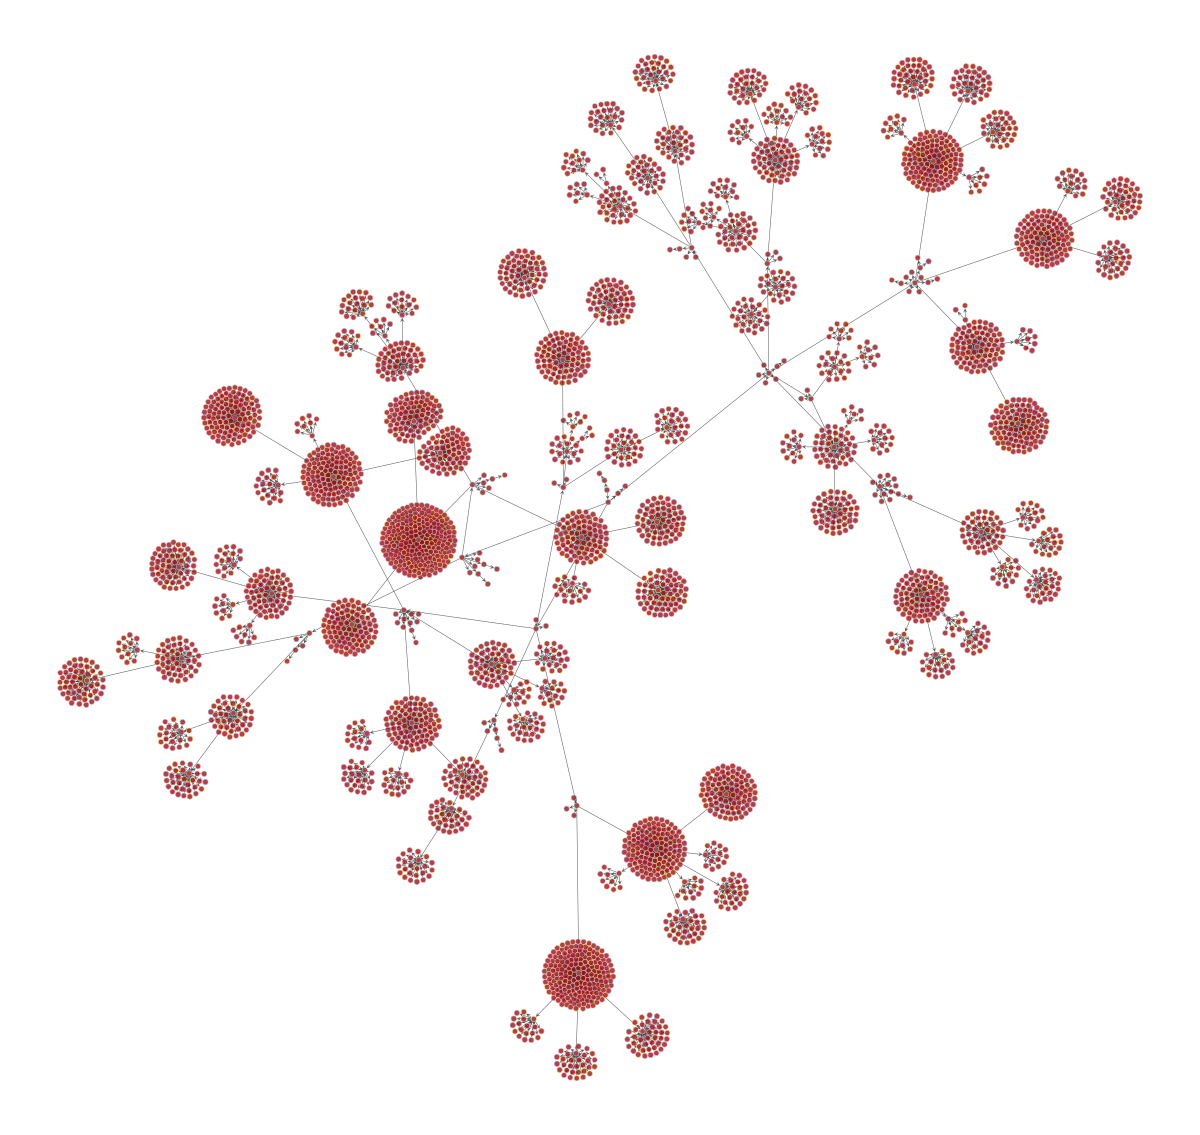

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7efc285a1700, at 0x7efc2839ee50>

In [59]:
graph_draw(x[0], vertex_color = x[1])

In [62]:
x[0]

<Graph object, directed, with 4132 vertices and 4131 edges, at 0x7efc285a1700>

In [65]:
nested_block_df = create_nestedBlock_df(gf, state_min)

In [66]:
nested_block_df

Gene Degree    E_corr    B1  B2  B3 B4 B5
0     FBgn0024733    211  0.445620  1394  12  20  4  0
1     FBgn0023537     73  0.397302   799  84  14  4  0
2     FBgn0000108    225  0.436224   389  34   6  2  0
3     FBgn0025640     16  0.362250   617  71   8  0  0
4     FBgn0025638      3  0.375419  1186  43  24  0  0
...           ...    ...       ...   ...  ..  .. .. ..
2017  FBgn0021906    107  0.432894   617  71   8  0  0
2018  FBgn0028481      2  0.326209  1336  52   6  2  0
2019  FBgn0031306     56  0.376361  1624  52   6  2  0
2020  FBgn0031313     28  0.393526   525  68  24  0  0
2021  FBgn0031305    200  0.419100   115  69   9  4  0

[2022 rows x 8 columns]

In [69]:
nested_block_df.to_csv("../data/1502genes-Control_Head-hsbm-fit_df.csv")